In [3]:
import random
import torch
import pandas as pd
import numpy as np
import json
import os
import copy
from torch import dropout, nn
from torch.optim import AdamW, Adam
from transformers import AutoModel, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import RobertaForSequenceClassification
from transformers import RobertaModel
from transformers import get_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics as metrics
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re
from nltk.tokenize import sent_tokenize


random.seed(42)
reprocess_raw =  False # whether to re-read the raw data and create combo files
reshuffle_data = False  # whether to reprocess the document lists


##### HYPERPARAMETERS

data_size_reduce = 1 # multiplier for making small datasets 
                     # (only works if reshuffle_data=True)

batch_size = 8 # documents

learning_rate = 5e-5 # sets AdamW optimizaiton learning rate
                     # scales scales with each training loop if scheduler is on

dropout_rate = 1e-1 # sets same dropout for roberta and for classification layer

normalizer_before_class = False # toggle the normalizer before the classification layer
use_lr_scheduler = False  # toggle the linear learning rate scheduler

n_epochs = 4 # baseline probably minimizes after 4 Epochs'

##### end HPs

task_map = {'Quantity':1,'MeasuredProperty':2,'MeasuredEntity':3,'Qualifier':4}
num_classes = len(task_map)

# model_name = 'roberta-base'
# model_name = 'allenai/biomed_roberta_base'
model_name = 'allenai/cs_roberta_base'


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = 'cpu' # uncomment this to make debugging models easier
                 # because CPU errors are more clear

run_name = model_name.split('/')[-1] +'_bs-'+str(batch_size)+\
                                        '_lr-'+str(learning_rate)+\
                                        '_drop-'+str(dropout_rate)+\
                                        '_norm-'+str(normalizer_before_class)[0]+\
                                        '_sched-'+str(use_lr_scheduler)[0]

print(run_name)

cs_roberta_base_bs-8_lr-5e-05_drop-0.1_norm-F_sched-F


In [4]:
currentdir = os.getcwd() # ~/MeasEval/baselines

combopath_txt = os.path.join(currentdir, "../data/raw/combo/text/")
combopath_annot = os.path.join(currentdir, "../data/raw/combo/tsv/")

interimpath = os.path.join(currentdir, "../data/interim/")

outputpath = os.path.join(currentdir, "../data/output/")

runoutpath = os.path.join(outputpath,run_name+'/')

In [5]:
runoutpath

'/home/michelle/MeasEval/baselines/../data/output/cs_roberta_base_bs-8_lr-5e-05_drop-0.1_norm-F_sched-F/'

In [6]:
try: os.makedirs(runoutpath)
except: pass

In [7]:
def process_raw_txt(docs):
    processesd_txt = {}
    remove_markers = True

    cnt_toks = {"figs.": 0, "fig.": 0, "et al.": 0,
            "ref.": 0, "eq.": 0, "e.g.": 0,
            "i.e.": 0, "nos.": 0, "no.": 0,
            "spp.": 0
            }
    regex_end_checker = [".*[a-zA-Z]figs\.$", 
                        ".*[a-zA-Z]fig\.$",
                        ".*[a-zA-Z]et al\.$",
                        ".*[a-zA-Z]ref\.$",
                        ".*[a-zA-Z]eq\.$",
                        ".*[a-zA-Z]e\.g\.$",
                        ".*[a-zA-Z]i\.e\.$",
                        ".*[a-zA-Z]nos\.$",
                        ".*[a-zA-Z]no\.$",
                        ".*[a-zA-Z]spp\.$",
                        # figs., fig., et al., Ref., Eq., e.g., i.e., Nos., No., spp.
                    ]

    assert len(cnt_toks) == len(regex_end_checker)

    for docId, doc in docs.items():
        flag = False
        sentences = sent_tokenize(doc)

        fixed_sentence_tokens = []
        curr_len = 0
        for s in sentences:
            if flag == True:
                assert s[0] != ' '
                white_length = doc[curr_len:].find(s[0])

                prev_len = len(fixed_sentence_tokens[-1])
                fixed_sentence_tokens[-1] = fixed_sentence_tokens[-1] + (" "*white_length) + s

                assert fixed_sentence_tokens[-1][prev_len+white_length] == doc[curr_len+white_length], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = white_length + len(s)
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len
            else:
                if len(fixed_sentence_tokens) != 0:
                    assert s[0] != ' '
                    white_length = doc[curr_len:].find(s[0])
                    fixed_sentence_tokens.append( (" "*white_length) + s )
                else:
                    fixed_sentence_tokens.append(s)
                assert fixed_sentence_tokens[-1][0] == doc[curr_len], (fixed_sentence_tokens, doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = len(fixed_sentence_tokens[-1])
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len

            lower_cased_s = fixed_sentence_tokens[-1].lower()
            flag = False
            if remove_markers:
                for i, k in enumerate(cnt_toks):
                    this_regex_pattern = regex_end_checker[i]
                    if lower_cased_s.endswith(k) and re.match(this_regex_pattern, lower_cased_s) == None:
                        cnt_toks[k] += 1
                        flag = True
                        break

        processesd_txt[docId] = ''.join(fixed_sentence_tokens)
    return processesd_txt


In [8]:
def read_data(reprocess_raw = False):

    if reprocess_raw == True:
        docIds = []
        combo_txt = {}
        for fn in os.listdir(combopath_txt):
            docIds.append(fn[:-4])
            path = combopath_txt+fn
            with open(path) as textfile:
                    text = textfile.read()
                    #[:-4] strips off the .txt to get the id
                    combo_txt[fn[:-4]] = text

        combo_annot = pd.DataFrame()
        for fn in os.listdir(combopath_annot):
            path = combopath_annot+fn
            file = pd.read_csv(path,delimiter='\t',encoding='utf-8')
            combo_annot = pd.concat([combo_annot, file],ignore_index=True)

        combo_txt = process_raw_txt(combo_txt)
        assert docIds == list(combo_txt.keys()), (len(docIds), len(list(combo_txt.keys())))

        with open(interimpath+'combo_txt.json','w') as f:
            json.dump(combo_txt, f)

        combo_annot.to_csv(interimpath+'combo_annot.csv')

        return docIds, combo_txt, combo_annot
    else:
        combo_annot = pd.read_csv(interimpath+'combo_annot.csv')

        with open(interimpath+'combo_txt.json','r') as f:
            combo_txt = json.load(f)

        docIds = list(combo_txt.keys())
    
        return docIds, combo_txt, combo_annot

In [36]:
combo_docs, combo_txt, combo_annot = read_data(reprocess_raw = reprocess_raw)

In [37]:
#### shuffle and split data

if reshuffle_data:
    random.seed(42)

    random.shuffle(combo_docs)

    percent_to_test = .1
    percent_to_dev = .2
    percent_to_train =  1 - percent_to_dev - percent_to_test

    n_doc = len(combo_docs)
    split_train = int(np.round(n_doc * percent_to_train))
    split_dev = split_train + int(np.round(n_doc * percent_to_dev))

    train_docs = combo_docs[:split_train]
    dev_docs = combo_docs[split_train:split_dev]
    test_docs = combo_docs[split_dev:]

    train_docs = random.sample(train_docs, int(len(train_docs)*data_size_reduce))
    dev_docs = random.sample(dev_docs, int(len(dev_docs)*data_size_reduce))
    test_docs = random.sample(test_docs, int(len(test_docs)*data_size_reduce))

    with open(interimpath+'train_docs.json','w') as f:
        json.dump(train_docs, f)
    with open(interimpath+'dev_docs.json','w') as f:
        json.dump(dev_docs, f)
    with open(interimpath+'test_docs.json','w') as f:
        json.dump(test_docs, f)

else:

    with open(interimpath+'train_docs.json','r') as f:
        train_docs = json.load(f)
    with open(interimpath+'dev_docs.json','r') as f:
        dev_docs = json.load(f)
    with open(interimpath+'test_docs.json','r') as f:
        test_docs = json.load(f)

In [38]:
########## Tokenizer ###########

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [39]:
def process_annotation_set(annot_set):

    annot_set_processed = []

    annot_set['comboIds'] = annot_set[['docId','annotId']].agg('_'.join, axis=1)
    annot_set.set_index('comboIds',inplace=True)

    for comboId in list(annot_set.index):
        
        docId = annot_set.loc[comboId]['docId']
        annotId = annot_set.loc[comboId]['annotId']
        annotSet = annot_set.loc[comboId]['annotSet']
        annotType = annot_set.loc[comboId]['annotType']
        annotSpan = [annot_set.loc[comboId]['startOffset'],annot_set.loc[comboId]['endOffset']]

        ent_annot_processed = {
            'comboId':comboId,
            'docId':docId,
            'annotId':annotId,
            'annotSet':annotSet,
            'annotType':annotType,
            'annotSpan':annotSpan,
            'subSpanType':np.nan,
            'linkId':np.nan,
            'linkSpan':np.nan,
            'subSpan':np.nan,
            'unit':np.nan,
            'unitEncoded':np.nan,
            'misc':np.nan
        }
        
        other = annot_set.loc[comboId]['other']
        if isinstance(other,str):
            otherDict = json.loads(str(other))

            if annot_set.loc[comboId]['annotType'] != 'Quantity':

                ent_annot_processed['subSpanType'] = list(otherDict.keys())[0]
                link = list(otherDict.values())[0]

                ent_annot_processed['linkId'] = link
                linkIdx = docId+'_'+link
                linkSpan = [int(annot_set.loc[linkIdx]['startOffset']),int(annot_set.loc[linkIdx]['endOffset'])]
                ent_annot_processed['linkSpan'] = linkSpan

                spanEnds = annotSpan + linkSpan
                ent_annot_processed['subSpan'] = [min(spanEnds),max(spanEnds)]

            elif 'unit' in list(otherDict.keys()):
                unit = otherDict['unit']
                ent_annot_processed['unit'] = unit
                ent_annot_processed['unitEncoded'] = tokenizer.encode(unit)[1:-1]
            else:
                ent_annot_processed['misc'] = otherDict


        annot_set_processed.append(ent_annot_processed)
   
    return pd.DataFrame.from_dict(annot_set_processed).set_index('comboId')

combo_annot_processed = process_annotation_set(combo_annot)
combo_annot_processed.to_csv(interimpath+'combo_annot_processed.csv')
combo_annot_processed.sample(7)


,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S0022399913003358-1044_T12-2,S0022399913003358-1044,T12-2,2,Quantity,"[125, 135]",NaN,NaN,NaN,NaN,year,[180],NaN
S0967064513002774-1376_T2-7,S0967064513002774-1376,T2-7,7,MeasuredEntity,"[717, 735]",HasProperty,T3-7,"[740, 748]","[717, 748]",NaN,NaN,NaN
S0006322312001096-1275_T31-1,S0006322312001096-1275,T31-1,1,MeasuredEntity,"[31, 37]",HasProperty,T21-1,"[15, 23]","[15, 37]",NaN,NaN,NaN
S0257897213007573-959_T2-4,S0257897213007573-959,T2-4,4,MeasuredEntity,"[1514, 1530]",HasProperty,T4-4,"[1562, 1570]","[1514, 1570]",NaN,NaN,NaN
S2213158213000582-1340_T4-3,S2213158213000582-1340,T4-3,3,Qualifier,"[309, 311]",Qualifies,T2-3,"[225, 259]","[225, 311]",NaN,NaN,NaN
S0019103512003533-5251_T93-3,S0019103512003533-5251,T93-3,3,Quantity,"[529, 545]",NaN,NaN,NaN,NaN,K,[530],NaN
S0021979713004438-1907_T72-2,S0021979713004438-1907,T72-2,2,MeasuredEntity,"[979, 984]",HasQuantity,T22-2,"[973, 978]","[973, 984]",NaN,NaN,NaN


In [ ]:
# sam's notes

# docId = combo_annot_processed.loc['S0012821X13007309-1605_T32-2']['docId']

# demo_doc = combo_txt[docId]

# quant_span = combo_annot_processed.loc['S0012821X13007309-1605_T32-2']['annotSpan']
# print(quant_span)

# unit_txt = combo_annot_processed.loc['S0012821X13007309-1605_T32-2']['unit']
# print(unit_txt)

# ## add 10 characters of margin to search for the unit txt before and after the quant txt
# charSearchMargin = 10
# quant_txt = demo_doc[(quant_span[0]-charSearchMargin):(quant_span[1]+charSearchMargin)]
# print(quant_txt)

# ## remember to subtract off the margin
# unit_start = quant_txt.index(unit_txt) + quant_span[0] - charSearchMargin
# print(unit_start)

# unit_end = unit_start + len(unit_txt)
# print(unit_end)

# print(demo_doc[unit_start:unit_end])



        # print("docId of not found:\n", docId)
        # print("doc_text of not found:\n", doc_text)
        # print("annotSpan of not found:\n", quant_span)
        # print("quant_txt of not found:\n", quant_txt)
        # print("unit_txt of not found:\n", unit_txt)

        # comboId = S0016236113008041-3127_T1-4u  #concat to related Quantity
    # docId = S0016236113008041-3127  #copy from related Quantity
    # annotId = T1-4u  #concat to related Quantity
    # annotSet = 4   #copy from related Quantity
    # annotType = Unit    #new entry
    # annotSpan = [unit_start,unit_end]    #see code above
    # unit = unit_txt   #copy from related Quantity
    # all others NaN

In [40]:

# filter df to where it's not nan's
combo_annot_processed_units = combo_annot_processed
combo_annot_processed_units = combo_annot_processed_units[~combo_annot_processed_units['unit'].isna()] 

def get_unit_subspan_row_info(docId, annotId, annotSet, annotType, annotSpan, unit):
    """
    Input: combo_annot_processed_units columns (used as apply function across rows)
    Output: dict with info to generate new rows (not sure yet if it's going to look like 
    1 dict per row or 1 total dict..but currently putting 1 dict with all parameters for
    a new row into a new column)
    """

    unit_rows_dict = {}
    not_found_dict = {}

    comboId = docId + "_" + annotId
    docId = docId
    annotId = annotId
    annotSet = annotSet
    annotType = annotType
    annotSpan = annotSpan
    unit = unit
    
    # get unit span
    doc_text = combo_txt[docId]
    #print(doc_text)
    quant_span = annotSpan
    unit_txt = unit
    quant_txt = doc_text[quant_span[0]:quant_span[1]]

    # try to set unit start; works only if the units are found in the quantity span
    try:
        unit_start = quant_txt.index(unit_txt) + quant_span[0]
        unit_end = unit_start + len(unit_txt)

    # if not, then try to find units in an expanded quantity span
    except ValueError:

        try:
            ## add margin to quant span search window
            charSearchMargin = 20
            quant_txt = doc_text[(quant_span[0]-charSearchMargin):(quant_span[1]+charSearchMargin)]

            ## subtract margin
            unit_start = quant_txt.index(unit_txt) + quant_span[0] - charSearchMargin
            unit_end = unit_start + len(unit_txt)

        except ValueError:
            not_found_dict[comboId] = (docId, doc_text, annotSpan, quant_txt, unit)

    # set unit row vars
    unit_comboId = docId + "_" + annotId + "u"
    unit_docId = docId
    unit_annotId = annotId + "u"
    unit_annotSet = annotSet
    unit_annotType = "Unit"
    unit_annotSpan = (unit_start, unit_end)
    unit_subSpanType = np.nan
    unit_linkId = np.nan
    unit_linkSpan = np.nan
    unit_subSpan = np.nan
    unit_unit = unit
    unit_unitEncoded = np.nan
    unit_misc = np.nan

    # add into dict
    # unit_rows_dict[unit_comboId] = [unit_docId, unit_annotId, unit_annotSet, unit_annotType, unit_annotSpan,
    #                             unit_subSpanType, unit_linkId, unit_linkSpan, unit_subSpan,
    #                             unit_unit, unit_unitEncoded, unit_misc]

    unit_rows_dict['comboId'] = unit_comboId
    unit_rows_dict['docId'] = unit_docId
    unit_rows_dict['annotId'] = unit_annotId
    unit_rows_dict['annotSet'] = unit_annotSet
    unit_rows_dict['annotType'] = unit_annotType
    unit_rows_dict['annotSpan'] = list(unit_annotSpan)
    unit_rows_dict['subSpanType'] = unit_subSpanType
    unit_rows_dict['linkId'] = unit_linkId
    unit_rows_dict['linkSpan'] = unit_linkSpan
    unit_rows_dict['subSpan'] = unit_subSpan
    unit_rows_dict['unit'] = unit_unit
    unit_rows_dict['unitEncoded'] = unit_unitEncoded
    unit_rows_dict['misc'] = unit_misc

    if len(not_found_dict) == 0:
        pass
    else:
        # print("docId of not found:\n", not_found_dict[comboId][0])
        # print("doc_text of not found:\n", not_found_dict[comboId][1])
        # print("annotSpan of not found:\n", not_found_dict[comboId][2])
        # print("quant_txt of not found:\n'{}'".format( not_found_dict[comboId][3]))
        # print("unit_txt of not found:\n'{}'".format(not_found_dict[comboId][4]))
        # print()
        print(not_found_dict)
        #print()

    return unit_rows_dict


# combo_annot_processed_units['not_found'], 
combo_annot_processed_units['dict'] = combo_annot_processed_units.apply(lambda row: get_unit_subspan_row_info(
                                                                            row['docId'],
                                                                            row['annotId'],
                                                                            row['annotSet'],
                                                                            row['annotType'],
                                                                            row['annotSpan'],
                                                                            row['unit']
                                                                            ), axis=1)



/tmp/ipykernel_18955/105647183.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_annot_processed_units['dict'] = combo_annot_processed_units.apply(lambda row: get_unit_subspan_row_info(


In [41]:
combo_annot_processed_units

,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc,dict
comboId,,,,,,,,,,,,,
S0006322312001096-1136_T1-3,S0006322312001096-1136,T1-3,3,Quantity,"[205, 222]",NaN,NaN,NaN,NaN,participants,"[42038, 3277]",NaN,"{'comboId': 'S0006322312001096-1136_T1-3u', 'd..."
S0006322312001096-1136_T21-4,S0006322312001096-1136,T21-4,4,Quantity,"[233, 243]",NaN,NaN,NaN,NaN,years,[12857],NaN,"{'comboId': 'S0006322312001096-1136_T21-4u', '..."
S0006322312001096-1136_T12-5,S0006322312001096-1136,T12-5,5,Quantity,"[245, 248]",NaN,NaN,NaN,NaN,%,[207],NaN,"{'comboId': 'S0006322312001096-1136_T12-5u', '..."
S0006322312001096-1177_T2-6,S0006322312001096-1177,T2-6,6,Quantity,"[413, 429]",NaN,NaN,NaN,NaN,employees,"[32198, 5421]",NaN,"{'comboId': 'S0006322312001096-1177_T2-6u', 'd..."
S0006322312001096-1177_T1-7,S0006322312001096-1177,T1-7,7,Quantity,"[431, 439]",NaN,NaN,NaN,NaN,men,[2262],NaN,"{'comboId': 'S0006322312001096-1177_T1-7u', 'd..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S2213671113001306-908_T1-2,S2213671113001306-908,T1-2,2,Quantity,"[79, 84]",NaN,NaN,NaN,NaN,μm,"[47049, 119]",NaN,"{'comboId': 'S2213671113001306-908_T1-2u', 'do..."
S2213671113001306-910_T1-1,S2213671113001306-910,T1-1,1,Quantity,"[901, 908]",NaN,NaN,NaN,NaN,×,[6230],NaN,"{'comboId': 'S2213671113001306-910_T1-1u', 'do..."
S2213671113001306-910_T1-2,S2213671113001306-910,T1-2,2,Quantity,"[974, 981]",NaN,NaN,NaN,NaN,×,[6230],NaN,"{'comboId': 'S2213671113001306-910_T1-2u', 'do..."


In [49]:
newdf = pd.DataFrame(columns = ['comboId', 'docId', 'annotId', 'annotSet', 'annotType', 'annotSpan',
       'subSpanType', 'linkId', 'linkSpan', 'subSpan', 'unit', 'unitEncoded',
       'misc', 'dict'])

for i in combo_annot_processed_units['dict']:
       print(i['annotSpan'])
       newdf = pd.concat([newdf, pd.DataFrame(i)])

newdf = newdf.set_index(keys=['comboId'])

[210, 222]
[238, 243]
[247, 248]
[420, 429]
[436, 439]
[449, 454]
[558, 563]
[684, 689]
[772, 774]
[797, 802]
[1218, 1223]
[1251, 1252]
[1444, 1445]
[1498, 1504]
[1510, 1514]
[1538, 1544]
[1706, 1713]
[219, 220]
[251, 252]
[355, 356]
[522, 523]
[550, 551]
[149, 153]
[734, 735]
[753, 754]
[1020, 1021]
[1042, 1043]
[1103, 1115]
[1284, 1285]
[1292, 1293]
[223, 228]
[403, 408]
[434, 437]
[447, 451]
[461, 465]
[479, 483]
[659, 684]
[721, 722]
[729, 730]
[110, 114]
[281, 282]
[310, 311]
[440, 441]
[510, 511]
[326, 330]
[348, 349]
[415, 416]
[499, 500]
[600, 601]
[672, 673]
[755, 756]
[911, 912]
[592, 593]
[323, 328]
[405, 409]
[655, 660]
[787, 807]
[987, 988]
[1039, 1040]
[47, 48]
[638, 643]
[86, 88]
[289, 291]
[949, 952]
[105, 107]
[181, 183]
[391, 393]
[481, 482]
[571, 573]
[958, 959]
[684, 685]
[1074, 1076]
[33, 35]
[342, 344]
[535, 536]
[505, 506]
[708, 709]
[822, 824]
[977, 985]
[1027, 1039]
[596, 597]
[694, 695]
[1121, 1123]
[1195, 1196]
[1301, 1302]
[1360, 1362]
[751, 752]
[817, 820]


In [50]:
newdf

,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc,dict
comboId,,,,,,,,,,,,,
S0006322312001096-1136_T1-3u,S0006322312001096-1136,T1-3u,3,Unit,210,NaN,NaN,NaN,NaN,participants,NaN,NaN,NaN
S0006322312001096-1136_T1-3u,S0006322312001096-1136,T1-3u,3,Unit,222,NaN,NaN,NaN,NaN,participants,NaN,NaN,NaN
S0006322312001096-1136_T21-4u,S0006322312001096-1136,T21-4u,4,Unit,238,NaN,NaN,NaN,NaN,years,NaN,NaN,NaN
S0006322312001096-1136_T21-4u,S0006322312001096-1136,T21-4u,4,Unit,243,NaN,NaN,NaN,NaN,years,NaN,NaN,NaN
S0006322312001096-1136_T12-5u,S0006322312001096-1136,T12-5u,5,Unit,247,NaN,NaN,NaN,NaN,%,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S2213671113001306-910_T1-2u,S2213671113001306-910,T1-2u,2,Unit,981,NaN,NaN,NaN,NaN,×,NaN,NaN,NaN
S2213671113001306-910_T1-3u,S2213671113001306-910,T1-3u,3,Unit,1006,NaN,NaN,NaN,NaN,μm,NaN,NaN,NaN
S2213671113001306-910_T1-3u,S2213671113001306-910,T1-3u,3,Unit,1008,NaN,NaN,NaN,NaN,μm,NaN,NaN,NaN


In [42]:
# another apply fucntion across columsn that takes dict column and then generates new rows based on those
combo_annot_processed_units = combo_annot_processed_units.reset_index() 

def unit_dict_values_to_rows(unit_dictionary):
    """
    Input:
    Output: dataframe for units
    """

    new_df = pd.DataFrame(columns = ['comboId', 'docId', 'annotId', 'annotSet', 'annotType', 'annotSpan',
       'subSpanType', 'linkId', 'linkSpan', 'subSpan', 'unit', 'unitEncoded',
       'misc', 'dict'])
    unit_dictionary = unit_dictionary
    new_df = pd.concat([new_df, pd.DataFrame(unit_dictionary)])
    print(new_df)

    return new_df


unit_only_df = combo_annot_processed_units['dict'].apply(unit_dict_values_to_rows)
unit_only_df

                        comboId                   docId annotId annotSet  \
0  S0006322312001096-1136_T1-3u  S0006322312001096-1136   T1-3u        3   
1  S0006322312001096-1136_T1-3u  S0006322312001096-1136   T1-3u        3   

  annotType annotSpan subSpanType linkId linkSpan subSpan          unit  \
0      Unit       210         NaN    NaN      NaN     NaN  participants   
1      Unit       222         NaN    NaN      NaN     NaN  participants   

  unitEncoded misc dict  
0         NaN  NaN  NaN  
1         NaN  NaN  NaN  
                         comboId                   docId annotId annotSet  \
0  S0006322312001096-1136_T21-4u  S0006322312001096-1136  T21-4u        4   
1  S0006322312001096-1136_T21-4u  S0006322312001096-1136  T21-4u        4   

  annotType annotSpan subSpanType linkId linkSpan subSpan   unit unitEncoded  \
0      Unit       238         NaN    NaN      NaN     NaN  years         NaN   
1      Unit       243         NaN    NaN      NaN     NaN  years         Na

0                               comboId               ...
1                                comboId              ...
2                                comboId              ...
3                               comboId               ...
4                               comboId               ...
                              ...                        
1293                           comboId                ...
1294                           comboId                ...
1295                           comboId                ...
1296                           comboId                ...
1297                           comboId                ...
Name: dict, Length: 1298, dtype: object

In [41]:
df = combo_annot_processed

df[~df['unit'].isna()] 

# hey Michelle this works

,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S0006322312001096-1136_T1-3,S0006322312001096-1136,T1-3,3,Quantity,"[205, 222]",NaN,NaN,NaN,NaN,participants,"[42038, 3277]",NaN
S0006322312001096-1136_T21-4,S0006322312001096-1136,T21-4,4,Quantity,"[233, 243]",NaN,NaN,NaN,NaN,years,[12857],NaN
S0006322312001096-1136_T12-5,S0006322312001096-1136,T12-5,5,Quantity,"[245, 248]",NaN,NaN,NaN,NaN,%,[207],NaN
S0006322312001096-1177_T2-6,S0006322312001096-1177,T2-6,6,Quantity,"[413, 429]",NaN,NaN,NaN,NaN,employees,"[32198, 5421]",NaN
S0006322312001096-1177_T1-7,S0006322312001096-1177,T1-7,7,Quantity,"[431, 439]",NaN,NaN,NaN,NaN,men,[2262],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
S2213671113001306-908_T1-2,S2213671113001306-908,T1-2,2,Quantity,"[79, 84]",NaN,NaN,NaN,NaN,μm,"[47049, 119]",NaN
S2213671113001306-910_T1-1,S2213671113001306-910,T1-1,1,Quantity,"[901, 908]",NaN,NaN,NaN,NaN,×,[6230],NaN
S2213671113001306-910_T1-2,S2213671113001306-910,T1-2,2,Quantity,"[974, 981]",NaN,NaN,NaN,NaN,×,[6230],NaN


In [17]:

combo_annot_processed.loc[combo_annot_processed['docId']=='S0016236113008041-3171']

,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S0016236113008041-3171_T31-1,S0016236113008041-3171,T31-1,1,Quantity,"[283, 289]",NaN,NaN,NaN,NaN,kg,[9043],NaN
S0016236113008041-3171_T131-1,S0016236113008041-3171,T131-1,1,MeasuredEntity,"[266, 279]",HasQuantity,T31-1,"[283, 289]","[266, 289]",NaN,NaN,NaN
S0016236113008041-3171_T102-2,S0016236113008041-3171,T102-2,2,Quantity,"[325, 327]",NaN,NaN,NaN,NaN,ppm,"[3807, 119]",NaN
S0016236113008041-3171_T142-2,S0016236113008041-3171,T142-2,2,MeasuredProperty,"[189, 191]",HasQuantity,T102-2,"[325, 327]","[189, 327]",NaN,NaN,NaN
S0016236113008041-3171_T232-2,S0016236113008041-3171,T232-2,2,MeasuredEntity,"[57, 70]",HasProperty,T142-2,"[189, 191]","[57, 191]",NaN,NaN,NaN
S0016236113008041-3171_T12-2,S0016236113008041-3171,T12-2,2,Qualifier,"[354, 363]",Qualifies,T232-2,"[57, 70]","[57, 363]",NaN,NaN,NaN
S0016236113008041-3171_T253-3,S0016236113008041-3171,T253-3,3,Quantity,"[332, 340]",NaN,NaN,NaN,NaN,ppm,"[3807, 119]",NaN
S0016236113008041-3171_T243-3,S0016236113008041-3171,T243-3,3,MeasuredProperty,"[196, 198]",HasQuantity,T253-3,"[332, 340]","[196, 340]",NaN,NaN,NaN
S0016236113008041-3171_T233-3,S0016236113008041-3171,T233-3,3,MeasuredEntity,"[57, 70]",HasProperty,T243-3,"[196, 198]","[57, 198]",NaN,NaN,NaN


In [36]:
# filter all Quants w/ units -> list of rows

# for each Quant/unit annot:

docId = combo_annot_processed.loc['S0019103513005058-3154_T1-1']['docId']

demo_doc = combo_txt[docId]

quant_span = combo_annot_processed.loc['S0019103513005058-3154_T1-1']['annotSpan']
print(quant_span)

unit_txt = combo_annot_processed.loc['S0019103513005058-3154_T1-1']['unit']
print(unit_txt)

quant_txt = demo_doc[quant_span[0]:quant_span[1]]
print(quant_txt)

unit_start = quant_txt.index(unit_txt) + quant_span[0]
print(unit_start)

unit_end = unit_start + len(unit_txt)
print(unit_end)

print(demo_doc[unit_start:unit_end])

## add row for unit to combo_annot_processed:

# comboId = S0016236113008041-3127_T1-4u  #concat to related Quantity
# docId = S0016236113008041-3127  #copy from related Quantity
# annotId = T1-4u  #concat to related Quantity
# annotSet = 4   #copy from related Quantity
# annotType = Unit    #new entry
# annotSpan = [unit_start,unit_end]    #see code above
# unit = unit_txt   #copy from related Quantity
# all others NaN



[175, 189]
wt.%
1.3 ± 0.5 wt.%
185
189
wt.%


In [27]:
### insert special tokens for subspans (Sam)
# will make docs longer

# def char_map(doc_annot, task_map)


def tokenize_and_align_labels(
                                doc_list=combo_docs,
                                txt=combo_txt,
                                processed_annotation=combo_annot_processed,
                                tokenizer=tokenizer,
                                taskLabelMap=task_map
                            ):

    toks_with_labels = []
    special_ids = tokenizer.all_special_ids
    collisionDict = {}

    for doc in doc_list:
        within_doc_collision_count = 0
        # print(doc)
        # print(processed_annotation.loc[processed_annotation['docId'] == doc])
        doc_annot = processed_annotation.loc[processed_annotation['docId'] == doc]
        doc_annot.set_index('annotId',inplace=True)
        # print(doc_annot)

        encoded_txt = tokenizer(txt[doc], padding='max_length', max_length=512, truncation=True)
        encoded_tokens = encoded_txt['input_ids']
        # print(encoded_tokens)

        ############### Label Primary Spans ###############

        labelIds = np.full(len(encoded_tokens),-1)
        taskCharMap = {} # 
        taskCharList = []
        collision = False

        if len(doc_annot) > 0:
            for annot_idx in range(int(doc_annot['annotSet'].max())):
                # print(annot_idx)
                if collision:
                    taskCharMap = taskCharMapBackup
                taskCharMapBackup = copy.deepcopy(taskCharMap)
                collision = False
                spans = list(doc_annot.loc[doc_annot['annotSet']==annot_idx+1]['annotSpan'])
                annotset_tasks = list(doc_annot.loc[doc_annot['annotSet']==annot_idx+1]['annotType'])
                for i in range(len(spans)):
                    span = list(range(spans[i][0],spans[i][-1]))
                    annotset_task = annotset_tasks[i]
                    # print(span)
                    # print(annotset_task)
                    if annotset_task in taskLabelMap.keys():
                        for spanCharIdx in span:
                            if spanCharIdx in taskCharMap:
                                if taskCharMap[spanCharIdx] != taskLabelMap[annotset_task]:
                                    # print("="*45)
                                    # print("Collision detected in doc",doc)
                                    # print("Previous mapped task:",taskCharMap[spanCharIdx],"new mapped task:",taskLabelMap[annotset_task])
                                    # print("Current span:",span)
                                    # print("Second (offending) annotSet will not be included.")
                                    # print("="*45)
                                    collisionDict[doc + '_' + 
                                                  str(within_doc_collision_count 
                                                      + 1)] = span
                                    collision = True
                                    within_doc_collision_count += 1
                                    break
                            # print(spanCharIdx)
                            taskCharMap[spanCharIdx] = taskLabelMap[annotset_task]
                        if collision:
                            continue
                    else:
                        continue
    
                        # print(taskCharMap)
                            # taskAnnotIdCharMap[spanCharIdx] = annotId
            

        decoded = [''] * len(encoded_tokens)
        for tokenIdx, token in enumerate(encoded_tokens):
            
            if token not in special_ids:
                tokenCharStart = encoded_txt.token_to_chars(tokenIdx).start
                if tokenCharStart in list(taskCharMap.keys()):
                    labelIds[tokenIdx] = taskCharMap[tokenCharStart]
                    decoded[tokenIdx] = tokenizer.decode(token)
                else:
                    labelIds[tokenIdx] = 0
            else:
                labelIds[tokenIdx] = 0
        

        ############### Sub Spans Token Insertion and labeling ###############

        encoded_txt['doc_or_sent_id'] = doc
        encoded_txt['labels'] = labelIds
        
        toks_with_labels.append(encoded_txt)
        
    print("Total collisions avoided:", len(collisionDict))
    
    # return toks_with_labels
    return pd.DataFrame.from_dict(toks_with_labels), collisionDict

In [31]:
stage1_train_ds, train_collisions = tokenize_and_align_labels(
    doc_list=train_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)

# stage1_train_ds[stage1_train_ds['doc_or_sent_id']=='S0019103513005058-3154']

Total collisions avoided: 155


,attention_mask,doc_or_sent_id,input_ids,labels
87,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S0019103513005058-3154,"[0, 133, 20925, 32999, 17815, 36, 771, 7454, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [12]:
################# TOKENIZE #################

stage1_train_ds, train_collisions = tokenize_and_align_labels(
    doc_list=train_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_train_ds.to_csv(interimpath+'stage1_train_ds.csv')
stage1_n_train = stage1_train_ds.shape[0]


stage1_dev_ds, dev_collisions = tokenize_and_align_labels(
    doc_list=dev_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_dev_ds.to_csv(interimpath+'stage1_dev_ds.csv')
stage1_n_dev = stage1_dev_ds.shape[0]

stage1_test_ds, test_collisions = tokenize_and_align_labels(
    doc_list=test_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_test_ds.to_csv(interimpath+'stage1_test_ds.csv')
stage1_n_test = stage1_test_ds.shape[0]


Total collisions avoided: 130
Total collisions avoided: 25
Total collisions avoided: 18


In [13]:
stage1_dev_ds

,attention_mask,doc_or_sent_id,input_ids,labels
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S0960148113005727-904,"[0, 713, 115, 33, 1233, 714, 8819, 13, 5, 2694...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S0378383912000130-3755,"[0, 28965, 5, 86, 12, 22760, 9, 5, 29215, 1200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S0012821X13002185-1061,"[0, 133, 381, 42416, 2383, 673, 17218, 42416, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S016412121300188X-4617,"[0, 133, 220, 403, 892, 2939, 42959, 1437, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S0006322312001096-1248,"[0, 4993, 13380, 13, 1533, 49033, 1626, 36, 15...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
85,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S2213671113001306-1385,"[0, 4148, 78, 618, 23655, 10743, 36, 7033, 155...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
86,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S0164121213002641-2930,"[0, 47926, 112, 10975, 33347, 1499, 742, 6211,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
87,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S0038071711004354-2389,"[0, 133, 34255, 154, 4756, 634, 5, 80, 253, 12...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
88,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S2211124713006475-1195,"[0, 3972, 7118, 5, 11, 43486, 3611, 9, 1368, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
stage1_n_train

314

In [15]:
### Matt
# def shorten_txt_encoding(txt, shorten_by : int):       
#     pass...

# generate a list of docIds that have token collision after shortening

# toks = list(stage1_dev_ds.sample(1)['input_ids'])

# print(toks[0])

# tokenizer.decode(toks[0])

In [16]:
def batchify(tokenized_dataset, batch_size, device):
    num_examples = int(tokenized_dataset.shape[0] / batch_size)
    batch_sizes = [batch_size for x in range(num_examples)]
    last_batch_size = tokenized_dataset.shape[0] % batch_size
    if last_batch_size:
        batch_sizes.append(last_batch_size)
    # print(batch_sizes)

    batched_dataset = []

    idf_to_torch = lambda df : torch.tensor(np.array([list(map(int,r)) for r in df])).to(device)

    for idx, size in enumerate(batch_sizes):
        start = sum(batch_sizes[:idx])
        end = sum(batch_sizes[:idx]) + size - 1
        # print(start,end,idx)
        input_ids = idf_to_torch(tokenized_dataset['input_ids'].loc[start:end])
        attention_mask = idf_to_torch(tokenized_dataset['attention_mask'].loc[start:end])
        labels = idf_to_torch(tokenized_dataset['labels'].loc[start:end])
        doc_or_sent_id = list(tokenized_dataset['doc_or_sent_id'].loc[start:end])
        
        batch = {
            'input_ids':input_ids,
            'labels':labels,
            'attention_mask':attention_mask,
            'doc_or_sent_id':doc_or_sent_id

        }
        
        batched_dataset.append(batch)

    return batched_dataset

In [17]:
################# batchify ####################

batched_train_ds = batchify(stage1_train_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)
batched_dev_ds = batchify(stage1_dev_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)
batched_test_ds = batchify(stage1_test_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)


In [18]:
batched_train_ds[0]

{'input_ids': tensor([[    0, 41084,  7913,  ...,     1,     1,     1],
         [    0,   347,  3917,  ...,     1,     1,     1],
         [    0,   102,     4,  ...,     1,     1,     1],
         ...,
         [    0,   133, 21817,  ...,     1,     1,     1],
         [    0,   133, 24956,  ...,     1,     1,     1],
         [    0,   133, 43261,  ...,   176,    36,     2]], device='cuda:0'),
 'labels': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 3, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 3,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'),
 'doc_or_sent_id': ['S0168945213001805-4574',
  'S0925443913003037-654',
  'S037838391

In [19]:
demo_batch = 2

demo_batch = batched_train_ds[demo_batch]


demo_doc = demo_batch['doc_or_sent_id'][0]
demo_ids = demo_batch['input_ids'].cpu().numpy()[0]
demo_tokens = tokenizer.decode(demo_batch['input_ids'].cpu().numpy()[0])
demo_labels = demo_batch['labels'].cpu().numpy()[0]
demo_mask = demo_batch['attention_mask'].cpu().numpy()[0]
latch_print = False
labeled_tokens = ''
for id, lab in zip(demo_ids, demo_labels):
    if lab:
        labeled_tokens = labeled_tokens + tokenizer.decode(id) + ' '

print(task_map)


{'Quantity': 1, 'MeasuredProperty': 2, 'MeasuredEntity': 3, 'Qualifier': 4}


In [20]:
demo_doc

'S1873506113001116-1456'

In [21]:
print(demo_ids)

[    0 36949     5 29854  1633  1274    52  8085 13603  1323  6257     8
  2919     9    80  7465    12  3743 20280  3888   347  2301    11  2198
  6533  3023 14511    12  3743   433    11   727    12 18517  4003  1688
  7257   994     4    20  4590 22495  9486 42019 13884  9285     6  5204
  2919    11    49 46005  1588 41098   194     6     8  2340   449  1766
 42190    71 14434   291 33083     4  6068    14    65  9280     9  3112
  2919     9   255  6905   134  4590    11  2292 12247 46918    36   642
   541  2055   231  2055   733    43   969 27034   449  1766 42190    36
  3706     6 26166   975   322   635     6    89    16   117  1283    14
    24   197    28  9702     7     5  5436  2040     4    96   937     6
   682  2782   939  3888   347  2040  1274  1888 21921  1164    13     5
   434     9 44436  4590    14  6860   434 12340     4  2223   449  1766
 43938  3435 27034  4590    58   303 10930    71   251    12  1279 13426
   223   258 48059     8  5436  1274     6     5 13

In [22]:
print(demo_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 3 0 0
 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 3 3 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 4 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 1 0 0 3 0 0 0 0 0 0 0 0 0 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [23]:
print(demo_tokens)

<s>Using the optimized operating conditions we demonstrate serial passaging and expansion of two integration-free hiPSC lines in completely defined xeno-free media in 100-ml bioreactors. The cells exhibited homogeneous aggregate formation, steady expansion in their pluripotent state, and normal karyotype after ~ 20 passages. Note that one experiment of extended expansion of TNC1 cells in spinner flask (p30 + 6 + 21) showed abnormal karyotype (47, XXY). However, there is no evidence that it should be attributed to the suspension culture. In general, recently improved iPSC culture conditions reduce selective pressure for the growth of mutated cells that acquire growth advantages. Although karyotypically abnormal cells were found occasionally after long-term cultures under both adherent and suspension conditions, the frequency is low (5% of tested batches of hiPSCs and hESCs). The standard karyotyping or other genotyping methods like what we performed here will remain necessary to manage 

In [24]:
combo_annot_processed.loc[combo_annot['docId']==demo_doc]

,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S1873506113001116-1456_T1-1,S1873506113001116-1456,T1-1,1,Quantity,"[90, 93]",NaN,NaN,NaN,NaN,NaN,NaN,{'mods': ['IsCount']}
S1873506113001116-1456_T2-1,S1873506113001116-1456,T2-1,1,MeasuredEntity,"[94, 122]",HasQuantity,T1-1,"[90, 93]","[90, 122]",NaN,NaN,NaN
S1873506113001116-1456_T1-2,S1873506113001116-1456,T1-2,2,Quantity,"[164, 170]",NaN,NaN,NaN,NaN,ml,[18517],NaN
S1873506113001116-1456_T2-2,S1873506113001116-1456,T2-2,2,MeasuredEntity,"[171, 182]",HasQuantity,T1-2,"[164, 170]","[164, 182]",NaN,NaN,NaN
S1873506113001116-1456_T1-3,S1873506113001116-1456,T1-3,3,Quantity,"[309, 313]",NaN,NaN,NaN,NaN,NaN,NaN,"{'mods': ['IsCount', 'IsApproximate']}"
S1873506113001116-1456_T2-3,S1873506113001116-1456,T2-3,3,MeasuredEntity,"[314, 322]",HasQuantity,T1-3,"[309, 313]","[309, 322]",NaN,NaN,NaN
S1873506113001116-1456_T1-4,S1873506113001116-1456,T1-4,4,Quantity,"[841, 843]",NaN,NaN,NaN,NaN,%,[207],NaN
S1873506113001116-1456_T2-4,S1873506113001116-1456,T2-4,4,MeasuredProperty,"[693, 722]",HasQuantity,T1-4,"[841, 843]","[693, 843]",NaN,NaN,NaN
S1873506113001116-1456_T3-4,S1873506113001116-1456,T3-4,4,MeasuredEntity,"[847, 881]",HasProperty,T2-4,"[693, 722]","[693, 881]",NaN,NaN,NaN


In [25]:
print(labeled_tokens)

 two  integration  100  bi .  ~  passages .  k  after , 5  tested ). 


In [26]:
#### Stage 2 Stuff (not currently used)

# special_token_map = dict(zip(tokenizer.all_special_tokens,tokenizer.all_special_ids))

# demo_annots = combo_annot_processed.loc[combo_annot['docId']==demo_doc]

# demo_txt = combo_txt[demo_doc]

# encoded_demo_txt = tokenizer(demo_txt, padding='max_length', max_length=512, truncation=True)
# demo_token_startchar = []
# for idx, id in enumerate(encoded_demo_txt['input_ids']):
#     try: tokenCharStart = encoded_demo_txt.token_to_chars(idx).start
#     except: tokenCharStart = np.nan
#     demo_token_startchar.append(tokenCharStart)

# subSpan_ds = {}
# for comboId, annot in demo_annots.iterrows():
#     if isinstance(annot['subSpanType'],float): continue # nans are floats
#     print(comboId)
#     print(annot['annotType'])
#     print(annot['subSpanType'])
#     print(annot['subSpan'][0],annot['subSpan'][1])
#     subSpanRange = list(range(annot['subSpan'][0],annot['subSpan'][1]))
#     # print(subSpanRange)
#     subSpanIds = []
#     subSpanLabels = []
#     for id, label, startChar in zip(demo_ids, demo_labels, demo_token_startchar):
#         if startChar in subSpanRange:
#             subSpanIds.append(id)
#             subSpanLabels.append(label)
#     print(subSpanIds)
#     print(subSpanLabels)
#     print(tokenizer.decode(subSpanIds,skip_special_tokens=True))
#     print()



In [27]:
class Stage1model(nn.Module):
    def __init__(self, dropout=dropout_rate):
        super(Stage1model, self).__init__()
        self.mod = RobertaModel.from_pretrained(
                    model_name,
                    num_labels=num_classes+1,
                    hidden_dropout_prob=dropout,
                    output_hidden_states=True)
        self.norm = nn.BatchNorm1d(512, eps=self.mod.config.layer_norm_eps)
        self.drop = nn.Dropout(self.mod.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.mod.config.hidden_size, num_classes+1)

    def forward(self, input_ids, attention_mask):
        output = self.mod(input_ids=input_ids,attention_mask=attention_mask)
        y_hat = output.hidden_states[-1]
        if normalizer_before_class: y_hat = self.norm(y_hat)
        y_hat = self.drop(y_hat)
        y_hat = self.classifier(y_hat).permute(0,2,1)
        return y_hat

model = Stage1model().to(device)

model_new = model


Downloading:   0%|          | 0.00/625M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/cs_roberta_base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = AdamW(model.parameters(), lr=learning_rate)

n_training_steps = n_epochs * len(batched_train_ds)

if use_lr_scheduler:
    n_training_steps = n_epochs * len(batched_train_ds)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=n_training_steps
    )


def train_epoch(ds, criterion):

    model.train()

    ypred = []
    ytrue = []
    for idx, batch in enumerate(ds):

        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)
        
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        if use_lr_scheduler: lr_scheduler.step()

        progress_bar.update(1)
            
    return loss.item()



def eval_epoch(ds, criterion):

    model.eval()

    ypred = []
    ytrue = []
    with torch.no_grad():
        for idx, batch in enumerate(ds):

            labels = batch['labels']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            logits = model(input_ids, attention_mask)
            
            loss = criterion(logits, labels)

            for dlogits, dlabels in zip(logits.permute(0,2,1), labels):
                    for tlogits, tlabels in zip(dlogits, dlabels):
                        ypred.append(tlogits.argmax().item())
                        ytrue.append(tlabels.item())

            progress_bar.update(1)

    acc = metrics.accuracy_score(ytrue,ypred)
    report = classification_report(ytrue,ypred,
                                    labels=list(task_map.values()),
                                    target_names=list(task_map.keys()),
                                    output_dict=True,
                                    zero_division=0)

                                    

    return loss.item(), acc, report, ytrue, ypred

In [29]:
run_report = {  'epoch':[],
                'train_loss':[],
                'eval_train_loss':[],
                'eval_train_acc':[],
                'eval_train_ytrue':[],
                'eval_train_ypred':[],
                'eval_train_rpt':[],
                'eval_dev_loss':[],
                'eval_dev_acc':[],
                'eval_dev_ytrue':[],
                'eval_dev_ypred':[],
                'eval_dev_rpt':[],
             }

num_total_steps = n_epochs * (len(batched_train_ds) * 2 + len(batched_dev_ds))
progress_bar = tqdm(range(num_total_steps))

for epoch in range(n_epochs):
    run_report['epoch'].append(epoch)
    
    print(f"============ Begin Epoch {epoch+1} ============")

    loss = train_epoch(batched_train_ds, criterion)
    print(f"Train loss: {loss}")
    run_report['train_loss'].append(loss)
    
    output = eval_epoch(batched_train_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on train set loss: {loss}   accuracy: {acc}')
    run_report['eval_train_loss'].append(loss)
    run_report['eval_train_acc'].append(acc)
    run_report['eval_train_ytrue'].append(ytrue)
    run_report['eval_train_ypred'].append(ypred)
    run_report['eval_train_rpt'].append(report)

    output = eval_epoch(batched_dev_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on dev set loss: {loss}   accuracy: {acc}')
    run_report['eval_dev_loss'].append(loss)
    run_report['eval_dev_acc'].append(acc)
    run_report['eval_dev_ytrue'].append(ytrue)
    run_report['eval_dev_ypred'].append(ypred)
    run_report['eval_dev_rpt'].append(report)
    


  0%|          | 0/368 [00:00<?, ?it/s]

============ Begin Epoch 1 ============
Train loss: 67.88790893554688
Eval on train set loss: 63.73430252075195   accuracy: 0.979554388933121
Eval on dev set loss: 71.42604064941406   accuracy: 0.9773871527777778
============ Begin Epoch 2 ============
Train loss: 44.32109451293945
Eval on train set loss: 43.47758102416992   accuracy: 0.9806180334394905
Eval on dev set loss: 53.151451110839844   accuracy: 0.9786241319444444
============ Begin Epoch 3 ============
Train loss: 33.9261474609375
Eval on train set loss: 36.770782470703125   accuracy: 0.9844807424363057
Eval on dev set loss: 28.55965805053711   accuracy: 0.9830946180555555
============ Begin Epoch 4 ============
Train loss: 25.80373764038086
Eval on train set loss: 26.577781677246094   accuracy: 0.9869252587579618
Eval on dev set loss: 24.756942749023438   accuracy: 0.9839626736111111


[[44707   131    40   160     0]
 [   51   395     3     0     0]
 [   51    10    68    51     0]
 [  118    23    10   171     0]
 [   54     6    13    18     0]]


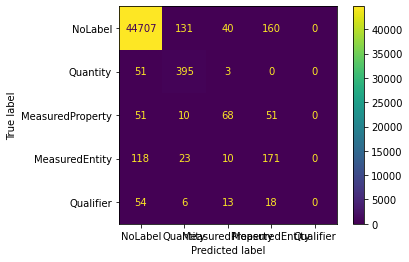

In [30]:
display_labels = list(task_map.keys())
display_labels.insert(0,str('NoLabel'))
cm = confusion_matrix(ytrue,ypred)
print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels).plot()
plt.show()

In [31]:
len(ypred)/512

90.0

In [32]:
len(ypred)

46080

In [33]:
ypred_by_doc = {}
ytrue_by_doc = {}
for i, doc in enumerate(dev_docs):

    ypred_by_doc[doc] = ypred[i*512:(i+1)*512]
    ytrue_by_doc[doc] = ytrue[i*512:(i+1)*512]

    # print(f'aligned {len(ypred_by_doc[doc])} predictions into doc {doc}')

#### Test doc-to-label alignment
for test_doc in dev_docs:
    input_lab = stage1_dev_ds.loc[stage1_dev_ds['doc_or_sent_id']==test_doc]['labels']
    assert ytrue_by_doc[test_doc] == list(input_lab.values[0])



In [34]:
def tabulate_metrics(reports):
    metrics = []
    for epoch in reports:
        # print(epoch)
        epoch_metrics = {}
        for task, rpt in task_map.items():
            for metric, value in epoch[task].items():
                epoch_metrics[str(task+'_'+metric)] = value
        metrics.append(epoch_metrics)

    metrics = pd.DataFrame.from_dict(metrics)
    metrics.index.rename('epoch')
    return metrics

In [35]:
train_set_metrics = tabulate_metrics(run_report['eval_train_rpt'])
train_set_metrics

,Quantity_precision,Quantity_recall,Quantity_f1-score,Quantity_support,MeasuredProperty_precision,MeasuredProperty_recall,MeasuredProperty_f1-score,MeasuredProperty_support,MeasuredEntity_precision,MeasuredEntity_recall,MeasuredEntity_f1-score,MeasuredEntity_support,Qualifier_precision,Qualifier_recall,Qualifier_f1-score,Qualifier_support
0,0.000000,0.000000,0.000000,1296,0.000000,0.000000,0.000000,663,0.000000,0.000000,0.000000,1002,0.0,0.0,0.0,326
1,0.771812,0.177469,0.288582,1296,0.000000,0.000000,0.000000,663,0.000000,0.000000,0.000000,1002,0.0,0.0,0.0,326
2,0.594044,0.877315,0.708411,1296,0.454301,0.254902,0.326570,663,0.449935,0.345309,0.390740,1002,0.0,0.0,0.0,326
3,0.681511,0.932870,0.787622,1296,0.530917,0.375566,0.439929,663,0.468318,0.641717,0.541474,1002,0.0,0.0,0.0,326


In [36]:
dev_set_metrics = tabulate_metrics(run_report['eval_dev_rpt'])
dev_set_metrics

,Quantity_precision,Quantity_recall,Quantity_f1-score,Quantity_support,MeasuredProperty_precision,MeasuredProperty_recall,MeasuredProperty_f1-score,MeasuredProperty_support,MeasuredEntity_precision,MeasuredEntity_recall,MeasuredEntity_f1-score,MeasuredEntity_support,Qualifier_precision,Qualifier_recall,Qualifier_f1-score,Qualifier_support
0,0.000000,0.000000,0.000000,449,0.000000,0.000000,0.000000,180,0.000000,0.000000,0.000000,322,0.0,0.0,0.0,91
1,0.833333,0.155902,0.262664,449,0.000000,0.000000,0.000000,180,0.000000,0.000000,0.000000,322,0.0,0.0,0.0,91
2,0.632550,0.839644,0.721531,449,0.536082,0.288889,0.375451,180,0.453441,0.347826,0.393673,322,0.0,0.0,0.0,91
3,0.699115,0.879733,0.779093,449,0.507463,0.377778,0.433121,180,0.427500,0.531056,0.473684,322,0.0,0.0,0.0,91


In [37]:
with open(runoutpath+'ypred.json','w') as f:
    json.dump(ypred_by_doc, f)

with open(runoutpath+'ytrue.json','w') as f:
    json.dump(ytrue_by_doc, f)

with open(runoutpath+'ypred_by_doc.json','w') as f:
    json.dump(ypred_by_doc, f)

with open(runoutpath+'ytrue_by_doc.json','w') as f:
    json.dump(ytrue_by_doc, f)

dev_set_metrics.to_csv(runoutpath+'dev_set_metrics')

train_set_metrics.to_csv(runoutpath+'train_set_metrics')

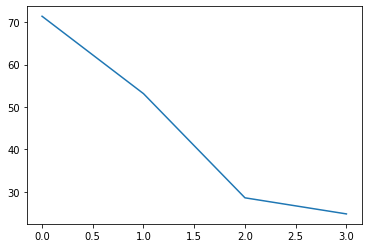

In [38]:
########################## loss plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['eval_dev_loss'])
plt.plot(x,y)
plt.show()

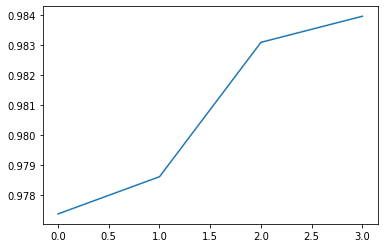

In [39]:
########################## accuracy plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['eval_dev_acc'])
plt.plot(x,y)
plt.show()